In [57]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
import numpy as np
from sklearn.metrics import accuracy_score
from nltk.stem.porter import PorterStemmer
import spacy
import os

In [58]:
pd.options.mode.chained_assignment = None
nltk.download('stopwords')

file_prefix = 'tweet'
text_field = 'text'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [59]:
csvname="filtered_dataset/"+file_prefix+".csv" #changed
# csvname=file_prefix+".csv" #changed
data_orig=pd.read_csv(csvname)
data=data_orig.copy()
data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
rows=len(data)

In [60]:
def filter_text(in_data):
  data = in_data.copy()
  for i in range (0,rows):
    oldtext=data[text_field][i] 
    newtext=' '.join(re.sub("(@[A-Za-z0-9]+)| (_URL_) | (#[A-Za-z0-9]+)|(\w+:\/\/\S+)"," ",str(oldtext)).split()) # removes hashtags, https links, usernames.
    newtext= re.sub('[^a-zA-Z0-9]'," ",str(newtext)) #removes all other characters other than English Alpha-Numeric Characters
    newtext=newtext.lower()
    newtext=newtext.split()
    data[text_field][i]=newtext
  return data

In [61]:
filtered_data=filter_text(data)
filtered_data

,text,class
0,"[much, of, the, focus, on, recently, has, been...",0
1,"[icymi, the, first, probable, case, of, monkey...",0
2,"[who, outbreak, not, yet, a, global, public, h...",0
3,"[according, to, the, cdc, monkeypox, is, usual...",0
4,"[lgbtq, advocates, and, health, care, organiza...",0
...,...,...
5782,"[an, effort, has, been, to, perpetuate, varian...",1
5783,"[an, effort, has, been, to, perpetuate, varian...",1
5784,"[it, seems, we, have, a, new, variant, coming,...",1
5785,"[news, from, what, i, gather, monkey, pox, has...",1


In [62]:
def porterstemming(in_data):
  data = in_data.copy()
  for i in range (0,rows):
    ps=PorterStemmer()
    oldtext=data[text_field][i]
    newtext= [ps.stem(word) for word in oldtext if word not in set(stopwords.words('english'))]
    newtext=' '.join(newtext)
    data[text_field][i]=newtext
  return data

In [63]:
portered_stemmed_data=porterstemming(filtered_data)
portered_stemmed_data

,text,class
0,much focu recent affect peopl richer countri c...,0
1,icymi first probabl case monkeypox west virgin...,0
2,outbreak yet global public health emerg via url,0
3,accord cdc monkeypox usual spread prolong dire...,0
4,lgbtq advoc health care organ rais alarm thurs...,0
...,...,...
5782,effort perpetu variant fake virus sarscov2 cov...,1
5783,effort perpetu variant fake virus sarscov2 cov...,1
5784,seem new variant come cours forget evil monkey...,1
5785,news gather monkey pox shingl side effect vacc...,1


In [64]:
def lemmatization(in_data):
  data = in_data.copy()
  spc = spacy.load("en_core_web_sm")
  for i in range (0,rows):
    oldtext = ' '.join(item for item in data[text_field][i])
    doc = spc(oldtext)
    newtext=' '.join([str(token) for token in doc if token not in set(stopwords.words("english"))])
    newtext = re.sub(r'\s+', ' ', newtext)
    data[text_field][i]=newtext
  return data

In [65]:
lemmatization_data=lemmatization(filtered_data)
lemmatization_data

,text,class
0,much of the focus on recently has been on how ...,0
1,icymi the first probable case of monkeypox in ...,0
2,who outbreak not yet a global public health em...,0
3,according to the cdc monkeypox is usually spre...,0
4,lgbtq advocates and health care organizations ...,0
...,...,...
5782,an effort has been to perpetuate variants of f...,1
5783,an effort has been to perpetuate variants of f...,1
5784,it seems we have a new variant coming out and ...,1
5785,news from what i gather monkey pox has been sh...,1


In [66]:
def create_corpus_and_y(data):
  y=np.array(data["class"])
  corpus=[data[text_field][i] for i in range(len(data)) if len(data)!=0]
  return (y,corpus)

In [67]:
y_portered,portered_corpus=create_corpus_and_y(portered_stemmed_data)
y_lemmatization,lemmatization_corpus=create_corpus_and_y(lemmatization_data)

In [68]:
def count_vec(corpus):
  from sklearn.feature_extraction.text import CountVectorizer
  cv = CountVectorizer(max_features = 1500)
  X = cv.fit_transform(corpus).toarray()
  return X

In [69]:
def tf_idf_vec(corpus):
  from sklearn.feature_extraction.text import TfidfVectorizer
  vectorizer = TfidfVectorizer(max_features=1500) # Add min_df, max_df parameters as well
  vectorizer.fit(corpus)
  X = vectorizer.transform(corpus)
  X=X.toarray()
  return X

In [70]:
X_portered_CV=count_vec(portered_corpus)
X_lemmatization_CV=count_vec(lemmatization_corpus)

In [71]:
df_portered_CV = pd.DataFrame(X_portered_CV)
df_portered_CV['class'] = y_portered
df_portered_CV

,0,1,2,3,4,5,6,7,8,9,...,1491,1492,1493,1494,1495,1496,1497,1498,1499,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5782,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5783,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5784,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5785,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [72]:
df_lemmatization_CV = pd.DataFrame(X_lemmatization_CV)
df_lemmatization_CV['class'] = y_lemmatization
df_lemmatization_CV

,0,1,2,3,4,5,6,7,8,9,...,1491,1492,1493,1494,1495,1496,1497,1498,1499,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5782,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5783,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5784,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5785,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [73]:
X_portered_TF_IDF=count_vec(portered_corpus)
X_lemmatization_TF_IDF=count_vec(lemmatization_corpus)

In [74]:
df_portered_TF_IDF = pd.DataFrame(X_portered_TF_IDF)
df_portered_TF_IDF['class'] = y_portered
df_portered_TF_IDF

,0,1,2,3,4,5,6,7,8,9,...,1491,1492,1493,1494,1495,1496,1497,1498,1499,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5782,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5783,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5784,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5785,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [75]:
df_lemmatization_TF_IDF = pd.DataFrame(X_lemmatization_TF_IDF)
df_lemmatization_TF_IDF['class'] = y_lemmatization
df_lemmatization_TF_IDF

,0,1,2,3,4,5,6,7,8,9,...,1491,1492,1493,1494,1495,1496,1497,1498,1499,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5782,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5783,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5784,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5785,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [76]:
#write processed dataset to .csv
os.makedirs('processed_dataset', exist_ok=True)
df_portered_CV.to_csv('processed_dataset/'+file_prefix+'_portered_CV.csv',index=False) 
df_lemmatization_CV.to_csv('processed_dataset/'+file_prefix+'_lemmatization_CV.csv',index=False)

In [77]:
#write processed dataset to .csv
os.makedirs('processed_dataset', exist_ok=True)
df_portered_TF_IDF.to_csv('processed_dataset/'+file_prefix+'_portered_TF_IDF.csv',index=False) 
df_lemmatization_TF_IDF.to_csv('processed_dataset/'+file_prefix+'_lemmatization_TF_IDF.csv',index=False)

## PCA starts

In [78]:
def split_data_train_test_split(X,y):
 from sklearn.model_selection import train_test_split
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
 return(X_train, X_test,y_train,y_test)

In [79]:
from sklearn.decomposition import PCA
def perform_PCA (X_train, y_train, total_components, n_components):
  pca = PCA(n_components=total_components, random_state=0)
  pca.fit(X_train)
  X_pca = pca.transform(X_train)

  print("Variance explained by all", total_components, "principal components =", sum(pca.explained_variance_ratio_ * 100))

  csum = np.cumsum(pca.explained_variance_ratio_ * 100)
  print(csum)
  print ()

  # plot 
  import matplotlib.pyplot as plt
  plt.plot(csum)
  plt.xlabel('Number of components')
  plt.ylabel('Explained variance')
  plt.savefig('elbow_plot.png', dpi=100)

  # find the number of components
  print (csum[n_components])

  x_train_pca=[x[:n_components] for x in X_pca]

  print (len(x_train_pca[0]))
  print ()

  return x_train_pca

In [80]:
# PCA on lemmatization data
y = df_lemmatization_TF_IDF['class']
X_lemmatization_tf = df_lemmatization_TF_IDF.copy()
X_lemmatization_tf.drop ('class', axis=1, inplace=True)

X_lemmatization_cv = df_lemmatization_CV.copy()
X_lemmatization_cv.drop ('class', axis=1, inplace=True)

In [81]:
X_train_cv, X_test_cv,y_train_cv,y_test_cv=split_data_train_test_split(X_lemmatization_cv,y)
X_train_tf, X_test_tf,y_train_tf,y_test_tf=split_data_train_test_split(X_lemmatization_tf,y)

Variance explained by all 1500 principal components = 100.00000000000021
[  7.93685008  11.99438498  15.49583841 ... 100.         100.
 100.        ]

97.9713406996071
950



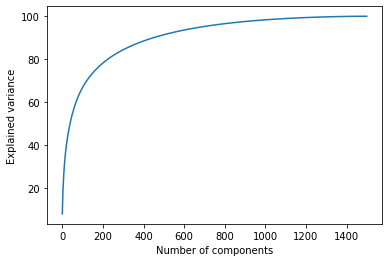

In [82]:
# PCA lemmatization CV
X_train_ = X_train_cv
y_train_ = y_train_cv
total_components = min(len(df_lemmatization_CV.columns)-1, len(X_train_))
n_components = 950
X_train = perform_PCA (X_train_, y_train_, total_components, n_components)

Variance explained by all 1500 principal components = 100.00000000000021
[  7.93685008  11.99438498  15.49583841 ... 100.         100.
 100.        ]

97.9713406996071
950



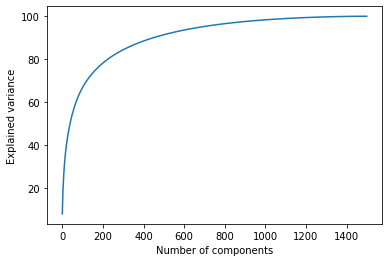

In [83]:
# PCA lemmatization TF IDF
X_train_ = X_train_tf
y_train_ = y_train_tf
total_components = min(len(df_lemmatization_TF_IDF.columns)-1, len(X_train_))
n_components = 950
X_train = perform_PCA (X_train_, y_train_, total_components, n_components)

In [84]:
# PCA on portered data
y = df_portered_TF_IDF['class']
X_portered_tf = df_portered_TF_IDF.copy()
X_portered_tf.drop ('class', axis=1, inplace=True)

X_portered_cv = df_portered_CV.copy()
X_portered_cv.drop ('class', axis=1, inplace=True)

In [85]:
X_train_cv, X_test_cv,y_train_cv,y_test_cv=split_data_train_test_split(X_portered_cv,y)
X_train_tf, X_test_tf,y_train_tf,y_test_tf=split_data_train_test_split(X_portered_tf,y)

Variance explained by all 1500 principal components = 99.99999999999996
[  6.08404144   8.80484442  11.05571979 ... 100.         100.
 100.        ]

97.0463008488567
950



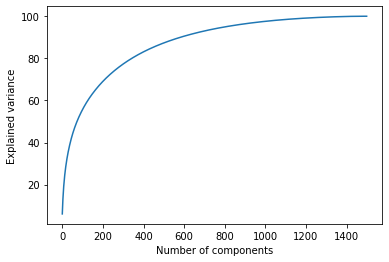

In [86]:
# PCA portered CV
X_train_ = X_train_cv
y_train_ = y_train_cv
total_components = min(len(df_portered_CV.columns)-1, len(X_train_))
n_components = 950
X_train = perform_PCA (X_train_, y_train_, total_components, n_components)

Variance explained by all 1500 principal components = 99.99999999999996
[  6.08404144   8.80484442  11.05571979 ... 100.         100.
 100.        ]

97.0463008488567
950



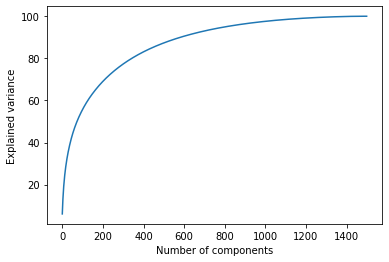

In [87]:
# PCA portered TF IDF
X_train_ = X_train_tf
y_train_ = y_train_tf
total_components = min(len(df_portered_TF_IDF.columns)-1, len(X_train_))
n_components = 950
X_train = perform_PCA (X_train_, y_train_, total_components, n_components)